In [212]:
import os
import pandas as pd

# Directory where the data is stored
base_dir = r'C:\Users\nirmi\Gut'
output_dir = r'C:\Users\nirmi\Gut\csv_output'  # Directory to save CSV files

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Function to convert TSV files to CSV
def convert_tsv_to_csv(base_dir, output_dir):
    for category in os.listdir(base_dir):
        category_dir = os.path.join(base_dir, category)
        if os.path.isdir(category_dir):
            # Create corresponding subdirectory in the output directory
            category_output_dir = os.path.join(output_dir, category)
            os.makedirs(category_output_dir, exist_ok=True)
            
            for file_name in os.listdir(category_dir):
                file_path = os.path.join(category_dir, file_name)
                if file_name.endswith('.txt'):
                    try:
                        # Locate the header row dynamically
                        with open(file_path, 'r') as file:
                            lines = file.readlines()
                            for i, line in enumerate(lines):
                                if line.strip().startswith('ncbi_taxon_id'):
                                    header_index = i
                                    break
                        
                        # Read the file starting from the header row
                        df = pd.read_csv(file_path, sep='\t', skiprows=header_index)
                        
                        # Check if the necessary columns exist
                        if 'ncbi_taxon_id' in df.columns and 'relative_abundance' in df.columns and 'scientific_name' in df.columns:
                            # Extract the relevant columns
                            df = df[['ncbi_taxon_id', 'relative_abundance', 'scientific_name']]
                            
                            # Save the DataFrame to a CSV file in the respective category directory
                            output_file_name = file_name.replace('.txt', '.csv')
                            output_file_path = os.path.join(category_output_dir, output_file_name)
                            df.to_csv(output_file_path, index=False)
                            print(f"Successfully converted {file_name} to {output_file_name} in {category_output_dir}")
                        else:
                            print(f"Skipping file {file_name}: required columns not found")
                    except Exception as e:
                        print(f"Error processing file {file_name}: {e}")

# Convert all TSV files to CSV
convert_tsv_to_csv(base_dir, output_dir)


Successfully converted relative_abundance_for_RUN_ERR1075893_taxonlevel_species.txt to relative_abundance_for_RUN_ERR1075893_taxonlevel_species.csv in C:\Users\nirmi\Gut\csv_output\Celiac
Successfully converted relative_abundance_for_RUN_ERR1089821_taxonlevel_species.txt to relative_abundance_for_RUN_ERR1089821_taxonlevel_species.csv in C:\Users\nirmi\Gut\csv_output\Celiac
Successfully converted relative_abundance_for_RUN_ERR1089916_taxonlevel_species.txt to relative_abundance_for_RUN_ERR1089916_taxonlevel_species.csv in C:\Users\nirmi\Gut\csv_output\Celiac
Successfully converted relative_abundance_for_RUN_ERR1091164_taxonlevel_species.txt to relative_abundance_for_RUN_ERR1091164_taxonlevel_species.csv in C:\Users\nirmi\Gut\csv_output\Celiac
Successfully converted relative_abundance_for_RUN_ERR1091479_taxonlevel_species.txt to relative_abundance_for_RUN_ERR1091479_taxonlevel_species.csv in C:\Users\nirmi\Gut\csv_output\Celiac
Successfully converted relative_abundance_for_RUN_SRR5946626

In [214]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import joblib

# Directory containing disease folders
data_dir = r"C:\Users\nirmi\GM"

# Function to load data and labels
def load_data(data_dir):
    data = []
    labels = []
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if file.endswith(".csv"):
                    df = pd.read_csv(file_path)
                    # Filter only numeric columns
                    numeric_df = df.select_dtypes(include=['float64', 'int64'])
                    if not numeric_df.empty:
                        data.append(numeric_df.mean().values)  # Mean of numeric columns
                        labels.append(folder)
    return pd.DataFrame(data), pd.Series(labels)

# Load data
X, y = load_data(data_dir)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler for later use in prediction
joblib.dump(scaler, 'scaler.pkl')

# Handle class imbalance using SMOTE with lower k_neighbors
smote = SMOTE(random_state=42, k_neighbors=3)  # Adjust k_neighbors to a lower value
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Optionally, compute class weights to handle imbalance (useful if not using SMOTE)
class_weights = compute_class_weight('balanced', classes=y.unique(), y=y)
class_weight_dict = {cls: weight for cls, weight in zip(y.unique(), class_weights)}

# Training a RandomForest Classifier with GridSearch for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

model = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_smote, y_train_smote)

# Best model from GridSearch
best_model = grid_search.best_estimator_

# Making predictions
y_pred = best_model.predict(X_test)

# Evaluating the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save the model for future use
joblib.dump(best_model, 'disease_classification_model.pkl')

# Function to load and preprocess the input CSV file for prediction
def preprocess_input(file_path):
    df = pd.read_csv(file_path)
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    if numeric_df.empty:
        raise ValueError("The CSV does not contain any numeric data.")
    features = numeric_df.mean().values.reshape(1, -1)  # Mean of numeric columns
    return features

# Function to predict the disease from an input CSV file
def predict_disease(file_path):
    features = preprocess_input(file_path)
    scaler = joblib.load('scaler.pkl')
    features = scaler.transform(features)
    model = joblib.load('disease_classification_model.pkl')
    prediction = model.predict(features)
    return prediction[0]

# Example usage for predicting disease from an unknown CSV file
sample_csv = r'C:\Users\nirmi\GM\Control\relative_abundance_for_RUN_SRR5946626_taxonlevel_species.csv'  # Replace with your CSV file path
predicted_disease = predict_disease(sample_csv)
print(f"The predicted disease is: {predicted_disease}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[[1 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 2 0 1 0]
 [1 0 0 1 0 0]
 [0 0 0 0 2 0]
 [0 0 0 0 0 1]]
                  precision    recall  f1-score   support

          Celiac       0.50      1.00      0.67         1
         Control       1.00      1.00      1.00         2
        Diabetes       1.00      0.67      0.80         3
         Diarhea       1.00      0.50      0.67         2
Non-Alcholic FLD       0.67      1.00      0.80         2
         Obesity       1.00      1.00      1.00         1

        accuracy                           0.82        11
       macro avg       0.86      0.86      0.82        11
    weighted avg       0.89      0.82      0.82        11

The predicted disease is: Control


In [215]:
# Define the file paths
tsv_file = r'C:\Users\nirmi\Trial\relative_abundance_for_RUN_ERR1857016_taxonlevel_species.txt'
csv_file = r'C:\Users\nirmi\Trial\relative_abundance_for_RUN_ERR1857016_taxonlevel_species.csv'

# Read the TSV file
df = pd.read_csv(tsv_file, sep='\t', comment='#')

# Select the desired columns
df_selected = df[['ncbi_taxon_id', 'relative_abundance', 'scientific_name']]

# Save the selected columns to a CSV file
df_selected.to_csv(csv_file, index=False)

print(f"Conversion complete. The CSV file has been saved to: {csv_file}")


Conversion complete. The CSV file has been saved to: C:\Users\nirmi\Trial\relative_abundance_for_RUN_ERR1857016_taxonlevel_species.csv


In [216]:
sample_csv = r'C:\Users\nirmi\Trial\relative_abundance_for_RUN_ERR1857016_taxonlevel_species.csv'  # Replace with your CSV file path
predicted_disease = predict_disease(sample_csv)
print(f"The predicted disease is: {predicted_disease}")

The predicted disease is: Non-Alcholic FLD


In [264]:
import pandas as pd
from tabulate import tabulate

# Load the CSV file containing disease and meal information
disease_food_table = pd.read_csv(r'C:/Users/nirmi/disease_food_table.csv')

# Assuming you already have your predicted disease
sample_csv = r'C:\Users\nirmi\Trial\relative_abundance_for_RUN_ERR1857016_taxonlevel_species.csv'  # Replace with your CSV file path
predicted_disease = predict_disease(sample_csv)  
print(f"The predicted disease is: {predicted_disease}")

# Look up the predicted disease in the disease food table
disease_row = disease_food_table[disease_food_table['Disease'] == predicted_disease]

# Display the meal plan in a basic table format using tabulate
if not disease_row.empty:
    meal_plan = {
        'Meal': ['Breakfast', 'Lunch', 'Dinner'],
        'Menu': [disease_row['Breakfast'].values[0], disease_row['Lunch'].values[0], disease_row['Dinner'].values[0]]
    }
    table = tabulate(pd.DataFrame(meal_plan), headers="keys", tablefmt="grid")
    print(table)
else:
    print("No meal plan found for the predicted disease.")


The predicted disease is: Non-Alcholic FLD
+----+-----------+-----------------------------------+
|    | Meal      | Menu                              |
+====+===========+===================================+
|  0 | Breakfast | Greek yogurt with berries         |
+----+-----------+-----------------------------------+
|  1 | Lunch     | Grilled chicken with leafy greens |
+----+-----------+-----------------------------------+
|  2 | Dinner    | Baked cod with roasted vegetables |
+----+-----------+-----------------------------------+


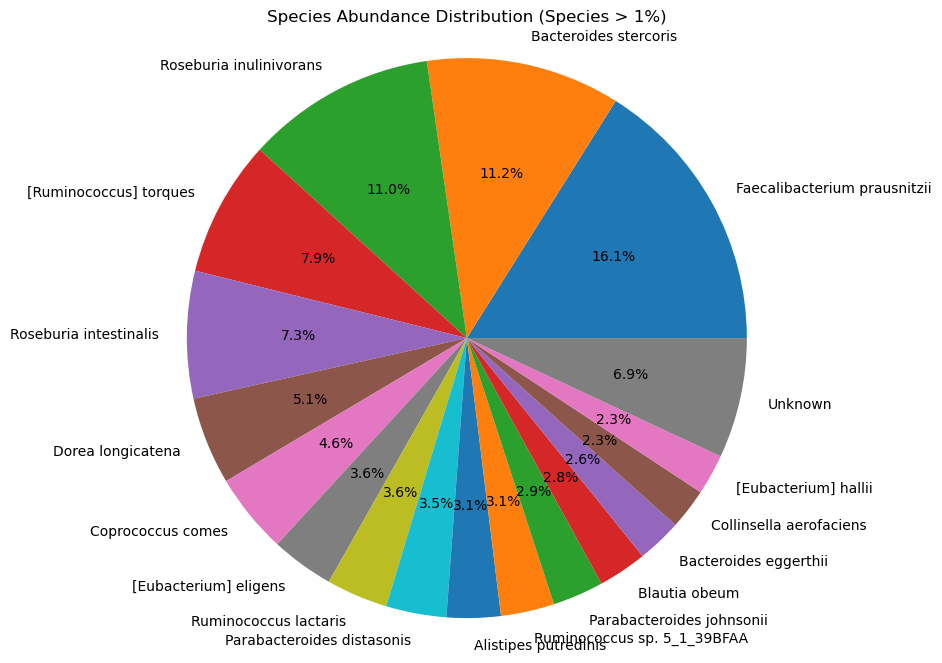

In [217]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the file path
csv_file = r'C:\Users\nirmi\Trial\relative_abundance_for_RUN_ERR1857016_taxonlevel_species.csv'

# Read the CSV file
df_selected = pd.read_csv(csv_file)

# Filter the DataFrame to include only species with more than 1% relative abundance
df_filtered = df_selected[df_selected['relative_abundance'] > 1]

# Create a pie chart for species abundance
plt.figure(figsize=(10, 8))
plt.pie(df_filtered['relative_abundance'], labels=df_filtered['scientific_name'], autopct='%1.1f%%')
plt.title('Species Abundance Distribution (Species > 1%)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()


In [218]:
# Define the file paths
tsv_file = r'C:\Users\nirmi\Trial\relative_abundance_for_RUN_ERR1076028_taxonlevel_species.txt'
csv_file = r'C:\Users\nirmi\Trial\relative_abundance_for_RUN_ERR1076028_taxonlevel_species.csv'

# Read the TSV file
df = pd.read_csv(tsv_file, sep='\t', comment='#')

# Select the desired columns
df_selected = df[['ncbi_taxon_id', 'relative_abundance', 'scientific_name']]

# Save the selected columns to a CSV file
df_selected.to_csv(csv_file, index=False)

print(f"Conversion complete. The CSV file has been saved to: {csv_file}")


Conversion complete. The CSV file has been saved to: C:\Users\nirmi\Trial\relative_abundance_for_RUN_ERR1076028_taxonlevel_species.csv


In [219]:
sample_csv = r'C:\Users\nirmi\Trial\relative_abundance_for_RUN_ERR1076028_taxonlevel_species.csv'  # Replace with your CSV file path
predicted_disease = predict_disease(sample_csv)
print(f"The predicted disease is: {predicted_disease}")

The predicted disease is: Diarhea


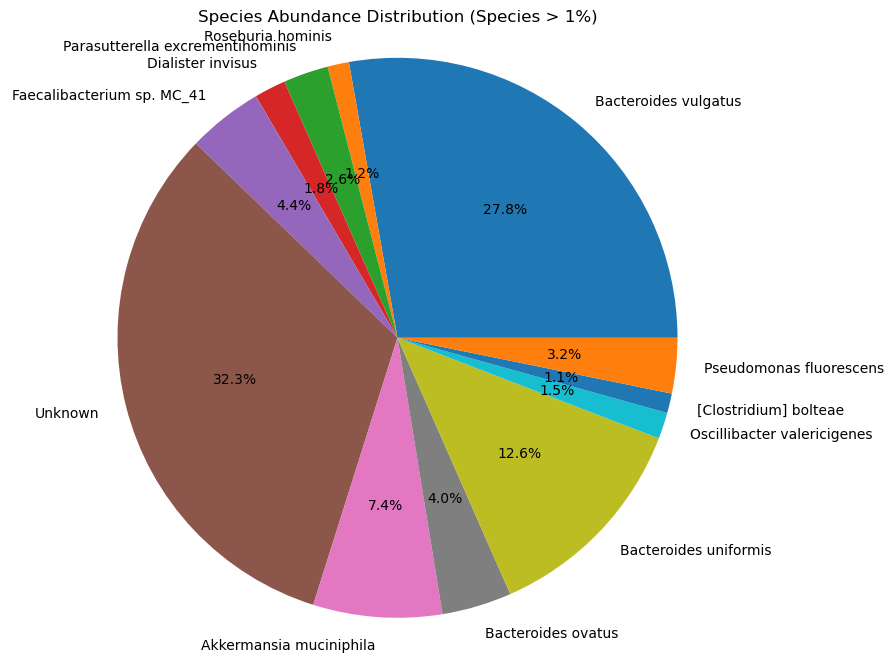

In [220]:
# Define the file path
csv_file = r'C:\Users\nirmi\Trial\relative_abundance_for_RUN_ERR1076028_taxonlevel_species.csv'

# Read the CSV file
df_selected = pd.read_csv(csv_file)

# Filter the DataFrame to include only species with more than 1% relative abundance
df_filtered = df_selected[df_selected['relative_abundance'] > 1]

# Create a pie chart for species abundance
plt.figure(figsize=(10, 8))
plt.pie(df_filtered['relative_abundance'], labels=df_filtered['scientific_name'], autopct='%1.1f%%')
plt.title('Species Abundance Distribution (Species > 1%)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()


In [260]:
import pandas as pd
from tabulate import tabulate

# Load the CSV file containing disease and meal information
disease_food_table = pd.read_csv(r'C:/Users/nirmi/disease_food_table.csv')

# Assuming you already have your predicted disease
sample_csv = r'C:\Users\nirmi\Trial\relative_abundance_for_RUN_ERR1076028_taxonlevel_species.csv'  # Replace with your CSV file path
predicted_disease = predict_disease(sample_csv)  
print(f"The predicted disease is: {predicted_disease}")

# Look up the predicted disease in the disease food table
disease_row = disease_food_table[disease_food_table['Disease'] == predicted_disease]

# Display the meal plan in a basic table format using tabulate
if not disease_row.empty:
    meal_plan = {
        'Meal': ['Breakfast', 'Lunch', 'Dinner'],
        'Menu': [disease_row['Breakfast'].values[0], disease_row['Lunch'].values[0], disease_row['Dinner'].values[0]]
    }
    table = tabulate(pd.DataFrame(meal_plan), headers="keys", tablefmt="grid")
    print(table)
else:
    print("No meal plan found for the predicted disease.")


The predicted disease is: Diarhea
+----+-----------+-------------------------------------+
|    | Meal      | Menu                                |
+====+===========+=====================================+
|  0 | Breakfast | Banana with rice porridge           |
+----+-----------+-------------------------------------+
|  1 | Lunch     | Boiled chicken with white rice      |
+----+-----------+-------------------------------------+
|  2 | Dinner    | Steamed carrots and boiled potatoes |
+----+-----------+-------------------------------------+
